In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import utils as ut

Now that we have seen the distribution and correlations of the values in this dataframe, lets try an initial model:

***Can we predict the world revenue of a movie based on the available numeric variables?***

In [31]:
model_df.isnull().sum()

budget              0
domestic_revenue    0
world_revenue       0
year                0
runtimeMinutes      0
averageRating       0
numVotes            0
dtype: int64

There are several nulls in the runtime column. As this makes up a significant portion of the data (~12%) I will impute these nulls with the median value from the column. From above, the runtime data is fairly normally distributed, so the median should be a viable option for imputing the nulls:

In [6]:
model_df['runtimeMinutes'] = model_df['runtimeMinutes'].fillna(model_df['runtimeMinutes'].median())

Setting up model for the dependent variable 'world_revenue' using all independant variables:

In [13]:
df = model_df
dependant = model_df['world_revenue']
features = model_df[['budget','runtimeMinutes','averageRating','year','numVotes']]

***WORKING ON USING Function FROM functions.py***

In [14]:
fn.linear_model(df,dependant,features)

KeyError: "None of [Index([  2620000.0,  12300000.0,   8800000.0,  20221274.0,  25000076.0,\n        23698846.0,    887000.0,  17000000.0,   7097971.0,   1000000.0,\n       ...\n        24215385.0,   2529395.0,    533235.0,      5073.0,   7712436.0,\n         3613222.0, 310566162.0,  60278166.0,   3503761.0,    150191.0],\n      dtype='float64', length=6165)] are in the [columns]"

In [15]:
y = model_df['world_revenue']
X = model_df[['budget','runtimeMinutes','averageRating','year','numVotes']]
X = sm.add_constant(X) 

model = sm.OLS(y, X) 
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          world_revenue   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     1925.
Date:                Thu, 21 Nov 2024   Prob (F-statistic):               0.00
Time:                        11:07:33   Log-Likelihood:            -1.2344e+05
No. Observations:                6165   AIC:                         2.469e+05
Df Residuals:                    6159   BIC:                         2.469e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.007e+08   2.47e+08      0.

Just realized that budget is massively larger than the rest of the columns. Normalizing data and running again:

In [72]:
y = model_df['world_revenue']
X = model_df[['budget','runtimeMinutes','averageRating','year','numVotes']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 
X_scaled = sm.add_constant(X_scaled)

model = sm.OLS(y, X_scaled) 
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          world_revenue   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     1925.
Date:                Sat, 02 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:38:06   Log-Likelihood:            -1.2344e+05
No. Observations:                6165   AIC:                         2.469e+05
Df Residuals:                    6159   BIC:                         2.469e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.008e+08   1.53e+06     65.927      0.0

Dropping year from the independant variables as it has the lowest t-value, and a p-value above 0.05. After that, dropping variables resulted in a worse r-squared so the final model is as follows:

In [79]:
y = model_df['world_revenue']
X = model_df[['budget','runtimeMinutes','averageRating','numVotes']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 
X_scaled = sm.add_constant(X_scaled)

model = sm.OLS(y, X_scaled) 
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          world_revenue   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     2406.
Date:                Sat, 02 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:49:19   Log-Likelihood:            -1.2344e+05
No. Observations:                6165   AIC:                         2.469e+05
Df Residuals:                    6160   BIC:                         2.469e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.008e+08   1.53e+06     65.927      0.0

Checking Residuals of model:

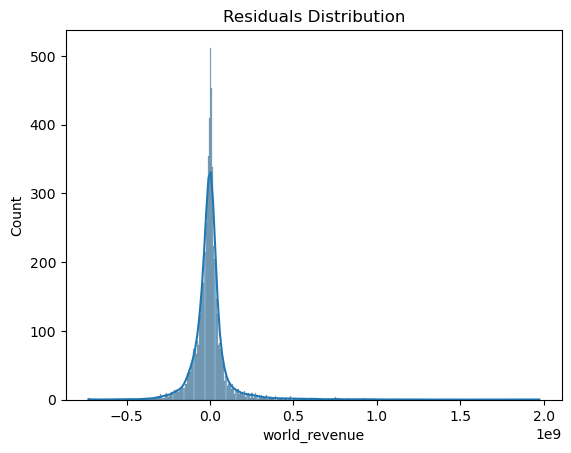

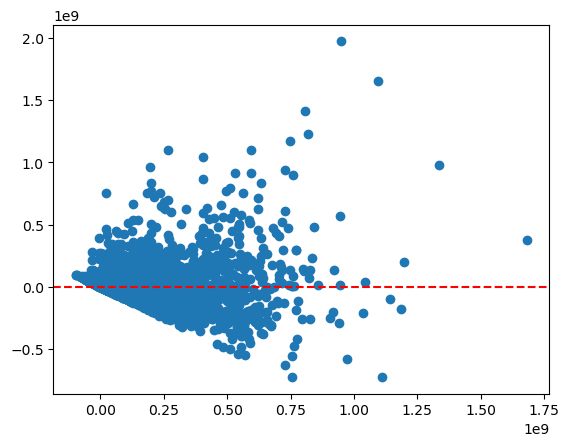

In [82]:
residuals = y - results.predict(X_scaled)
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.show()

plt.scatter(results.predict(X_scaled), residuals)
plt.axhline(0, color='red', linestyle='--')
plt.show()

There is an issue with the above scatter plot. May be caused by inter-related variables or have something to do with the scaling. Need to review before re-attempting model

Checking for outliers in each column used in the above model and re-attempting:

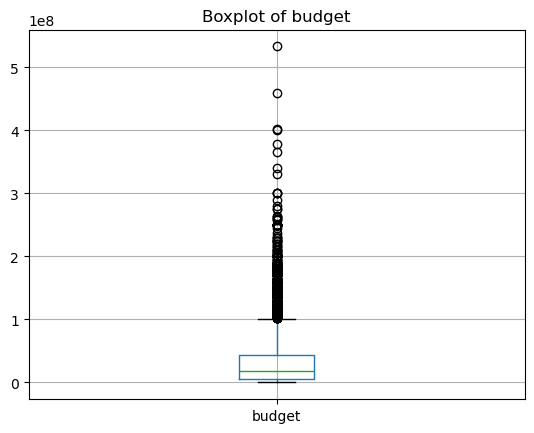

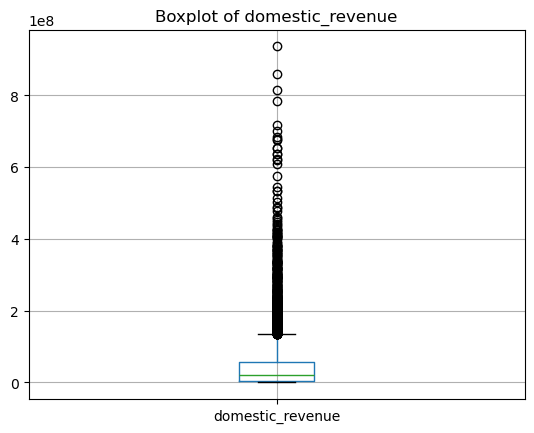

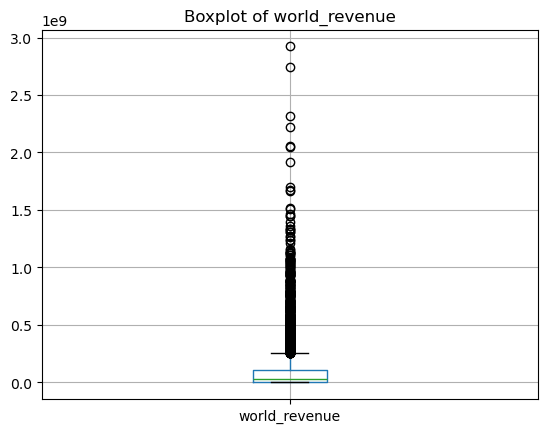

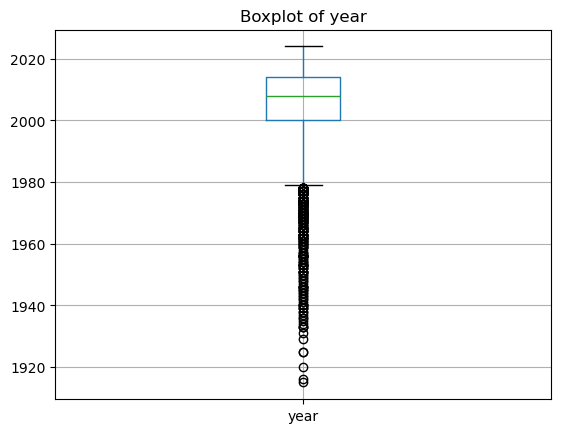

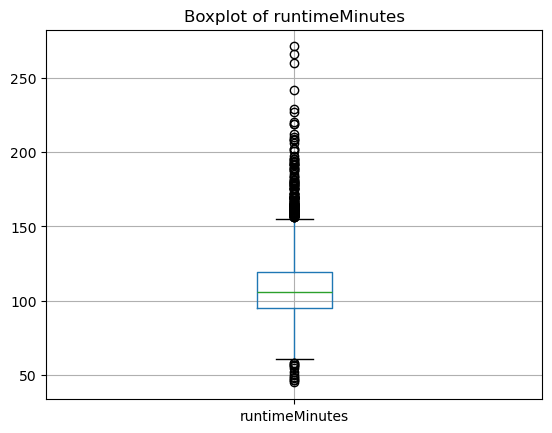

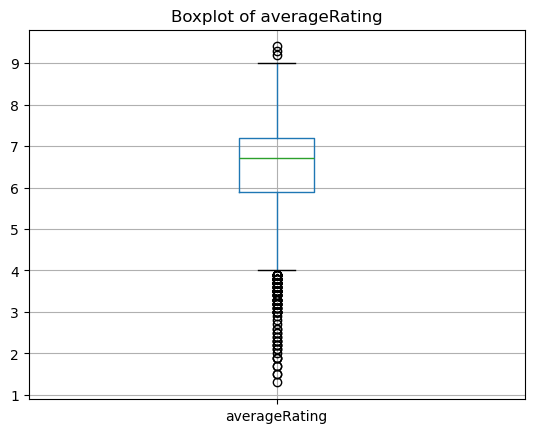

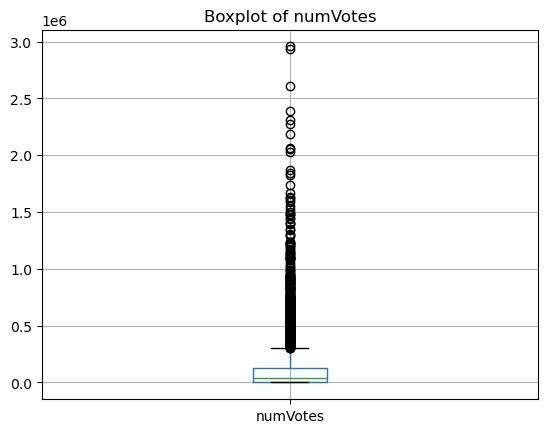

In [7]:
# Plot boxplots for each column
for column in model_df.columns:
    plt.figure()
    model_df.boxplot([column])
    plt.title(f'Boxplot of {column}')
    plt.show()

The boxplots indicate a large amount of outliers still present in our model's dataset. Using IQR below, we can see around 1400 rows are defined as outliers. This represents ~20% of our dataset. Further review needed before we can drop any of these data points. As we are trying to predict world revenue, an outlier in the budget category is something we may want to keep, for example.

In [8]:
# Calculate Q1 and Q3
Q1 = model_df.quantile(0.25)
Q3 = model_df.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers_iqr = ((model_df < (Q1 - 1.5 * IQR)) | (model_df > (Q3 + 1.5 * IQR)))
outliers = model_df[outliers_iqr.any(axis=1)]
print(outliers)

          budget  domestic_revenue  world_revenue  year  runtimeMinutes  \
0      1455000.0         2620000.0      2620000.0  1968           113.0   
1      2500000.0        12300000.0     12300000.0  1971            98.0   
2      1800000.0         8800000.0      8800000.0  1973            93.0   
3     11000000.0        20000000.0     20221274.0  1975           185.0   
4      7000000.0        25000000.0     25000076.0  1976           119.0   
...          ...               ...            ...   ...             ...   
6155  25000000.0        13657115.0     24215385.0  2011           140.0   
6156  10000000.0         2529395.0      2529395.0  2011            97.0   
6157   3000000.0          508714.0       533235.0  2011            93.0   
6161  61000000.0        81697192.0    310566162.0  2015           131.0   
6163  15000000.0         2423467.0      3503761.0  2016            91.0   

      averageRating  numVotes  
0               5.6      3557  
1               6.3     42119  
2  

I am having a difficult time rationalizing dropping data for the sake of the models accuracy. At this time I will proceed with the present outliers and instead try implementing new features to use in the model:

In [9]:
genre = pd.read_csv('Data/genres.csv')

In [13]:
genre.columns

Index(['date', 'Movie', 'budget', 'domestic_revenue', 'world_revenue', 'year',
       'originalTitle', 'isAdult', 'startYear', 'runtimeMinutes', 'genres',
       'averageRating', 'numVotes'],
      dtype='object')

In [19]:
#runtimeMinutes was incorrect data type and had some incorrect nulls. Fixed datatype
genre['runtimeMinutes'] = pd.to_numeric(genre['runtimeMinutes'], errors='coerce')

In [20]:
# pivot data to get some data by each genre
g_pivot = genre.pivot_table(
                        index='genres',
                        values=['budget','world_revenue','runtimeMinutes','averageRating'],
                        aggfunc={'budget': 'mean','world_revenue': 'mean',
                                'runtimeMinutes': 'mean','averageRating': 'mean'}
)
#g_pivot

In [24]:
# Saving this pivot as a csv to easily reference later
g_pivot.to_csv('data_by_genre.csv')

Built out data set data_by_genre to use in model. Will try to add some new columns based off this data. For example, adding average revenue to a movie depending on the genre

Creating a similar pivot table below using the movies data set. Some movies have multiple genres (horror, thriller, mystery) and I want to get the averages by these genre combinations as well

In [2]:
movies = pd.read_csv('Data/movies_tableau_V3.csv')

In [3]:
movies['runtimeMinutes'] = pd.to_numeric(movies['runtimeMinutes'], errors='coerce')

In [4]:
movie_pivot = movies.pivot_table(
                        index='genres',
                        values=['budget','world_revenue','runtimeMinutes','averageRating'],
                        aggfunc={'budget': 'mean','world_revenue': 'mean',
                                'runtimeMinutes': 'mean','averageRating': 'mean'}
)
#movie_pivot

In [6]:
model_df_genre = pd.merge(movies, movie_pivot, on='genres')
model_df_genre

Building function for model to avoid repetition:

In [8]:
def linear_model(df,dependant,features):
    y = df[dependant]
    X = df[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X) 
    X_scaled = sm.add_constant(X_scaled)

    model = sm.OLS(y, X_scaled) 
    results = model.fit()
    print(results.summary())

Retrying model with average revenue generated by genre:

In [9]:
df = model_df_genre
dependant = ['world_revenue_x']
features = ['budget_x','runtimeMinutes_x','averageRating_x','world_revenue_y']

NameError: name 'model_df_genre' is not defined

In [13]:
model_df_genre['runtimeMinutes_x'] = model_df_genre['runtimeMinutes_x'].fillna(model_df_genre['runtimeMinutes_x'].median())

In [14]:
linear_model(df,dependant,features)

                            OLS Regression Results                            
Dep. Variable:        world_revenue_x   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     2057.
Date:                Wed, 20 Nov 2024   Prob (F-statistic):               0.00
Time:                        09:24:03   Log-Likelihood:            -1.2372e+05
No. Observations:                6165   AIC:                         2.475e+05
Df Residuals:                    6160   BIC:                         2.475e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.008e+08    1.6e+06     62.941      0.0

In [16]:
df = model_df_genre
dependant = ['world_revenue_x']
features = ['budget_x','averageRating_x','world_revenue_y'] #world_revenue_y is the average world revenue per genre

linear_model(df,dependant,features)

                            OLS Regression Results                            
Dep. Variable:        world_revenue_x   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     2742.
Date:                Wed, 20 Nov 2024   Prob (F-statistic):               0.00
Time:                        09:25:43   Log-Likelihood:            -1.2373e+05
No. Observations:                6165   AIC:                         2.475e+05
Df Residuals:                    6161   BIC:                         2.475e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.008e+08    1.6e+06     62.936      0.0

Model is worse with average revenue per genre. Seeing if the scaling was affecting things. Trying will unscaled variables:

In [17]:
def linear_model_unscaled(df,dependant,features):
    y = df[dependant]
    X = df[features]
    X = sm.add_constant(X)

    model = sm.OLS(y, X) 
    results = model.fit()
    print(results.summary())

In [18]:
df = model_df_genre
dependant = ['world_revenue_x']
features = ['budget_x','averageRating_x','world_revenue_y'] #world_revenue_y is the average world revenue per genre

linear_model_unscaled(df,dependant,features)

                            OLS Regression Results                            
Dep. Variable:        world_revenue_x   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     2742.
Date:                Wed, 20 Nov 2024   Prob (F-statistic):               0.00
Time:                        09:28:11   Log-Likelihood:            -1.2373e+05
No. Observations:                6165   AIC:                         2.475e+05
Df Residuals:                    6161   BIC:                         2.475e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -2.139e+08   1.09e+07    -

In [20]:
feature = pd.read_csv('Data/model.csv')
feature

,budget,domestic_revenue,world_revenue,year,isAdult,runtimeMinutes,averageRating,numVotes
0,1455000.0,2620000.0,2620000.0,1968,0,113.0,5.6,3557
1,2500000.0,12300000.0,12300000.0,1971,0,98.0,6.3,42119
2,1800000.0,8800000.0,8800000.0,1973,0,93.0,5.4,35911
3,11000000.0,20000000.0,20221274.0,1975,0,185.0,8.1,187337
4,7000000.0,25000000.0,25000076.0,1976,0,119.0,6.8,62211
...,...,...,...,...,...,...,...,...
6160,120000.0,0.0,3613222.0,2011,0,NaN,7.2,7
6161,61000000.0,81697192.0,310566162.0,2015,0,131.0,6.3,284986
6162,18000000.0,57027435.0,60278166.0,2015,0,100.0,5.6,11449
6163,15000000.0,2423467.0,3503761.0,2016,0,91.0,3.9,10834
